In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [1]:
%cd /content/gdrive/My Drive/kaggle/tps_sep/

/content/gdrive/My Drive/kaggle/tps_sep


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
!pip3 install -q tensorflow_decision_forests
import tensorflow_decision_forests as tfdf

In [25]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_solution.csv')

In [26]:
train.fillna(0, inplace = True)
test.fillna(0, inplace = True)

In [27]:
X = train.iloc[:, 1:-1]
y = train['claim']

target = test.iloc[:, 1:]

In [6]:
from sklearn.preprocessing import StandardScaler

In [28]:
scaler = StandardScaler()

In [29]:
scaled_X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
scaled_X['claim'] = y
scaled_target = pd.DataFrame(scaler.transform(target), columns = X.columns)

In [9]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = .2, random_state = 42, stratify = y)

In [31]:
X_train = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, label = 'claim')
X_test = tfdf.keras.pd_dataframe_to_tf_dataset(X_test, label = 'claim')

In [32]:
pred_X = tfdf.keras.pd_dataframe_to_tf_dataset(scaled_target)

In [33]:
model = tfdf.keras.GradientBoostedTreesModel(num_trees = 200)
model.fit(X_train)

11974/11974 [==============================] - 106s 9ms/step


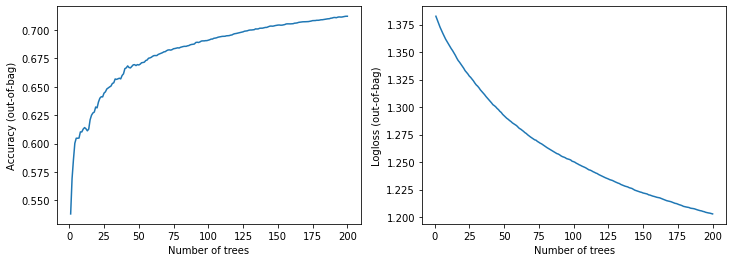

In [34]:
logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")
plt.show()

In [35]:
val_pred = model.predict(X_test)

In [36]:
from sklearn.metrics import roc_auc_score

In [37]:
roc_auc = roc_auc_score(y_test, val_pred)

In [38]:
roc_auc

0.7776733955645782

In [39]:
submission['claim'] = model.predict(pred_X)

In [40]:
submission.to_csv("tfdf.csv", index = False)